In [1]:
#  Step 1: Install Required Packages
!pip install -U scikit-learn xgboost matplotlib

In [5]:
#  Step 2: Mount Google Drive to Access Your Dataset Folder
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#  Step 3: Define Dataset Path in Drive
base_path = '/content/drive/MyDrive/Turbofan engine/'

In [8]:
!unzip -o Project6.zip


Archive:  Project6.zip
   creating: Turbofan engine/
  inflating: Turbofan engine/Damage Propagation Modeling.pdf  
  inflating: Turbofan engine/readme.txt  
  inflating: Turbofan engine/RUL_FD001.txt  
  inflating: Turbofan engine/RUL_FD002.txt  
  inflating: Turbofan engine/RUL_FD003.txt  
  inflating: Turbofan engine/RUL_FD004.txt  
  inflating: Turbofan engine/RUL_reader.py  
  inflating: Turbofan engine/test_FD001.txt  
  inflating: Turbofan engine/test_FD002.txt  
  inflating: Turbofan engine/test_FD003.txt  
  inflating: Turbofan engine/test_FD004.txt  
  inflating: Turbofan engine/train_FD001.txt  
  inflating: Turbofan engine/train_FD002.txt  
  inflating: Turbofan engine/train_FD003.txt  
  inflating: Turbofan engine/train_FD004.txt  


In [11]:
base_path = '/content/drive/MyDrive/Turbofan engine/'


In [12]:
base_path = '/content/Turbofan engine/'


In [13]:
import pandas as pd

# Set dataset path
base_path = '/content/Turbofan engine/'

# Define column names
cols = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
       [f'sensor_{i}' for i in range(1, 22)]

# Load train, test, and RUL files
train = pd.read_csv(base_path + "train_FD001.txt", sep="\s+", header=None)
test = pd.read_csv(base_path + "test_FD001.txt", sep="\s+", header=None)
rul = pd.read_csv(base_path + "RUL_FD001.txt", sep="\s+", header=None)

# Drop empty columns if any
train.dropna(axis=1, how='all', inplace=True)
test.dropna(axis=1, how='all', inplace=True)

# Assign column names
train.columns = cols
test.columns = cols


In [15]:
# Calculate max cycle for each engine
rul_train = train.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_train.columns = ['unit_number', 'max_cycle']

# Merge with train data
train = train.merge(rul_train, on='unit_number', how='left')

# Compute RUL
train['RUL'] = train['max_cycle'] - train['time_in_cycles']
train.drop('max_cycle', axis=1, inplace=True)

# Preview
train.head()



,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [16]:
# Rename rul column
rul.columns = ['RUL']

# Get the last cycle for each engine in test set
test_last = test.groupby('unit_number').last().reset_index()

# Keep only ID and last known cycle
test_last = test_last[['unit_number', 'time_in_cycles']]

# Append true RUL values
test_rul = pd.concat([test_last, rul], axis=1)

# Preview
test_rul.head()


,unit_number,time_in_cycles,RUL
0,1,31,112
1,2,49,98
2,3,126,69
3,4,106,82
4,5,98,91


In [17]:
# Drop weak/noisy sensors
drop_cols = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

# Keep strong sensor features
features = [col for col in train.columns if col.startswith('sensor') and col not in drop_cols]

# Prepare input/output for training
X_train = train[features]
y_train = train['RUL']

# Prepare test set (last reading of each engine)
X_test = test.groupby('unit_number').last()[features]
y_test = rul['RUL']


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


In [21]:
# Evaluation Metrics
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Performance on FD001 Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.2f}")



📊 Model Performance on FD001 Test Set:
RMSE: 34.09
MAE:  24.73
R²:   0.33


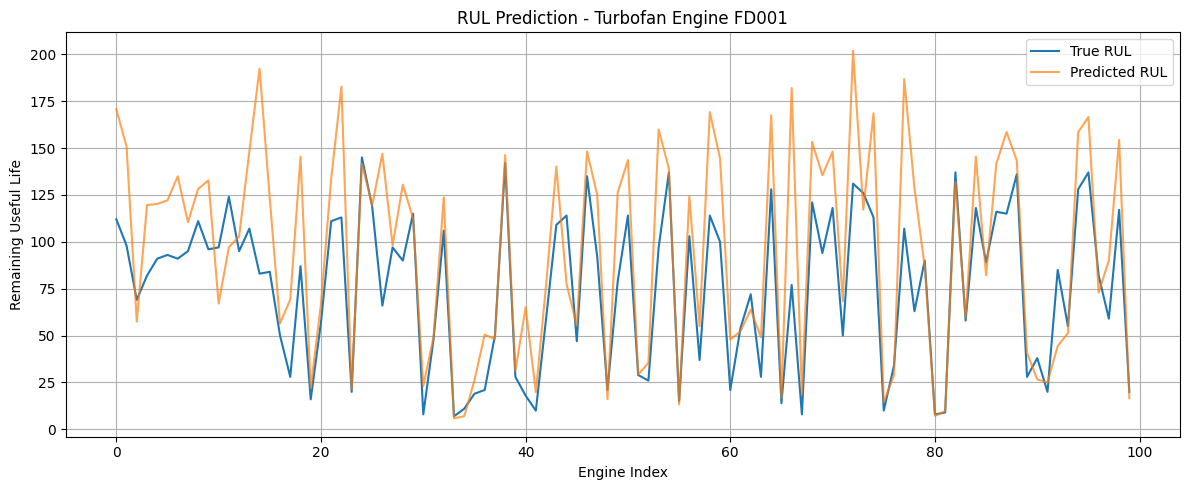

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='True RUL')
plt.plot(y_pred, label='Predicted RUL', alpha=0.7)
plt.xlabel("Engine Index")
plt.ylabel("Remaining Useful Life")
plt.title("RUL Prediction - Turbofan Engine FD001")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
